In [7]:
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.enums import Resampling
from rasterio.transform import from_origin, Affine
from rasterio.mask import mask
import geopandas as gpd
from scipy.interpolate import griddata
from osgeo import gdal, gdalconst
import xdem
import matplotlib.pyplot as plt

### 1. Loading and inspecting raster data with rasterio

To explore how raster data is stored in python when it is loaded with rasterio by answering the following questions:

1) What is stored in dem_src, what is stored in dem2020?
2) Explore the metadata. What are the dimensions, coordinate reference system, and resolution of this dataset?
3) Can you also derive the no-data value, and the elevation range of the DEM?
4) Plot the 2020 DEM (define some reasonable minimum and maximum values). What do you notice about the axes? Where in space is this data?
5) Plot the data again, passing plt.imshow() the correct extent.

In [9]:
#load with rasterio
with rasterio.open('./data/DEMs/silvretta-2020-2m.tif') as dem_src:
    dem2020 = dem_src.read(1)

In [10]:
# What datatypes are dem_src and dem2020, and what does dem2020 contain?
type(dem2020)

numpy.ndarray

In [11]:
# Explore metadata
# What is the file resolution, the image dimensions, the spatial resolution, and the no-data value?
dem_src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4623,
 'height': 3312,
 'count': 1,
 'crs': CRS.from_epsg(2056),
 'transform': Affine(2.0, 0.0, 2797549.5,
        0.0, -2.0, 1195031.0)}

In [35]:
# What is the elevation range of the Digital Elevation Model?
min = np.nanmin(dem2020)
max = dem2020.max()
print(min, max)

2031.3837 3312.1853


In [13]:
#mask no-data values for prettyness:
if dem_src.nodata is not None:
    dem2020 = np.ma.masked_equal(dem2020, dem_src.nodata)

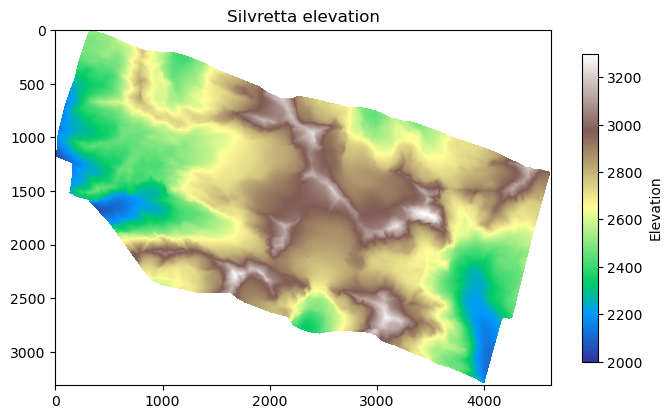

In [40]:
# Plot elevation using a reasonable range for the elevation. How might you query this if you don't know?
f, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(dem2020,
           vmin=2000, 
           vmax=3300, 
           cmap='terrain')
cbar = f.colorbar(cax, ax=ax, label='Elevation', shrink=0.5)
ax.set_title('Silvretta elevation')
plt.show()

In [37]:
bounds

BoundingBox(left=2797549.5, bottom=1188407.0, right=2806795.5, top=1195031.0)

In [42]:
# Plot elevation so that the data ends up on the right place on Earth!

# Use the bounds and attributes thereof to define the spatial extent of the DEM. 
bounds = dem_src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top] #left, right, bottom, top

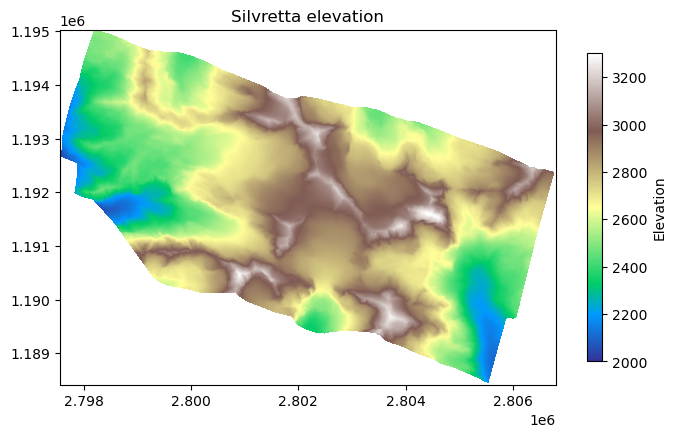

In [43]:
f, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(dem2020,
           extent=extent,
           vmin=2000, 
           vmax=3300, 
           cmap='terrain')
cbar = f.colorbar(cax, ax=ax, label='Elevation', shrink=0.5)
ax.set_title('Silvretta elevation')
plt.show()

### 2. Loading, reprojecting, and manipulating raster data with xdem

xdem is designed to work with elevation data, but it can also be used for other raster data. It's built on rasterio (and by association gdal), but it's a bit more packaged. Load the same dataset again and

1) Use the .plot() method and see how it plots. What do you notice / what is different with regard to using rasterio?
2) Take a look a the xdem [terrain attributes](https://xdem.readthedocs.io/en/stable/terrain.html) and try to plot a hillshade.
3) Load the ice thickness estimate from [Farinotti et al., 2019](https://www.nature.com/articles/s41561-019-0300-3) for Silvretta glacier and plot it. What do you notice with this?
4) Create a plot that shows the ice thickness over the hillshade, including the glacier outline and a colorbar for the ice thickness!
5) Already done? Load a second DEM and create and plot a difference map, showing the glacier outlines as well.


In [44]:
dem = xdem.DEM('./data/DEMs/silvretta-2020-2m.tif') #load the dataset

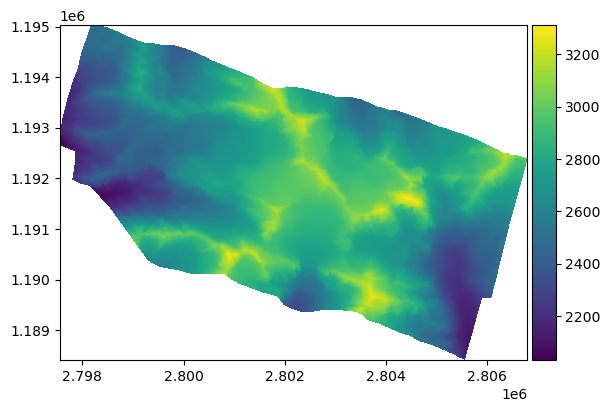

In [45]:
dem.plot() #notice how it already knows where it is in the world

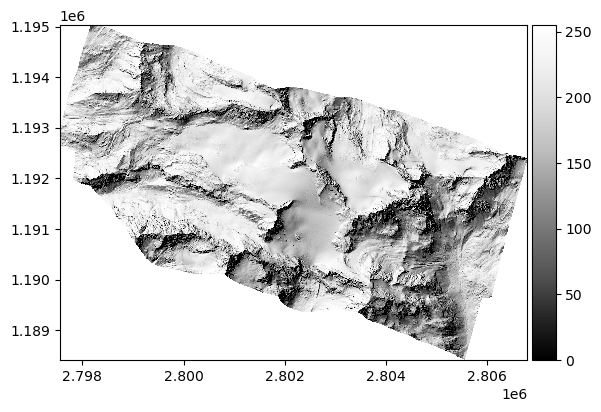

In [50]:
# Plot a hillshade. You might want to define a more appropriate colormap. 
xdem.terrain.hillshade(dem).plot(cmap='Greys_r')

In [51]:
# write the hillshade to file for future use!
hillshade = xdem.terrain.hillshade(dem)

Let's use xdem to load another raster dataset, namely the ice thickness estimate

In [52]:
rgi_thickness = xdem.DEM('./data/RGI60-11/RGI60-11.00804_thickness.tif') #Ice thickness estimate for Silvretta glacier from a global consensus estimate

In [98]:
reproject_rgi_thickness.bounds

BoundingBox(left=2797549.5, bottom=1188407.0, right=2806795.5, top=1195031.0)

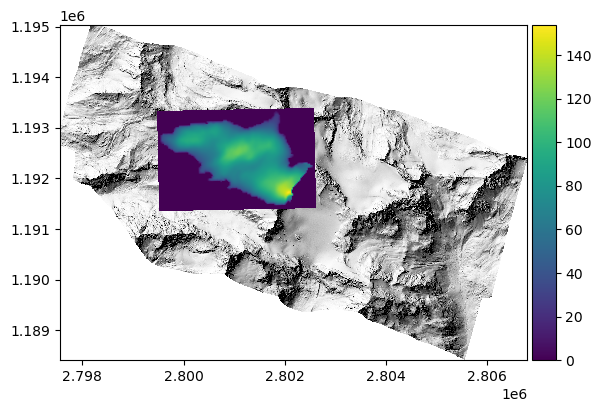

In [101]:
# plot the ice thickness! Can you plot it with the DEM?

reproject_rgi_thickness = rgi_thickness.reproject(hillshade)

f,ax = plt.subplots()
hillshade.plot(ax=ax, cmap='Greys_r', add_cbar=False)
reproject_rgi_thickness.plot(ax=ax)


What is the problem? Take a look here for a solution (once you have identified the problem ;-) [hint](https://xdem.readthedocs.io/en/stable/gen_modules/xdem.DEM.reproject.html))

In [103]:
# fix the problem! 
thickness_lv95 = rgi_thickness.reproject(dem)

In [104]:
# load our outline 
outline = gpd.read_file('./data/silvretta_outline.geojson')

Text(24.847222222222214, 0.5, 'Northing in m')

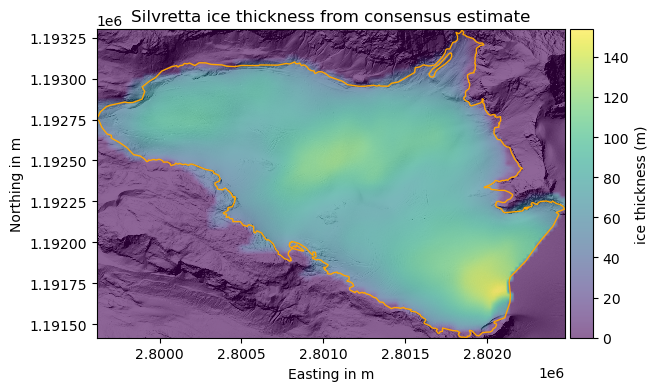

In [105]:
f, ax = plt.subplots()
hillshade.plot(ax=ax,
               cmap='Greys_r',
               add_cbar=False,
               alpha=1.0)

thickness_lv95.plot(ax=ax, 
              cmap='viridis',
              cbar_title='ice thickness (m)',
              alpha=0.6)
outline.plot(ax=ax, facecolor='none', edgecolor='orange')
ax.set_xlim([outline.bounds.minx[0], outline.bounds.maxx[0]])
ax.set_ylim([outline.bounds.miny[0], outline.bounds.maxy[0]])
ax.set_title('Silvretta ice thickness from consensus estimate')
ax.set_xlabel('Easting in m')
ax.set_ylabel('Northing in m')

In [106]:
# loading a second DEM and differencing them

In [107]:
dem2014 = xdem.DEM('./data/DEMs/2014_SILVRETTA_DSM_1m_LV95_LN02_CIR_low_raw.tif')

In [108]:
dem2014_reproj = dem2014.reproject(dem)

In [109]:
diff = dem2014_reproj-dem

In [110]:
sgi = gpd.read_file('data/sgi_2016/SGI_2016_glaciers.shp')

/home/fquaren/micromamba/envs/cords-geoprocessing-pv/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


(1188407.0, 1195031.0)

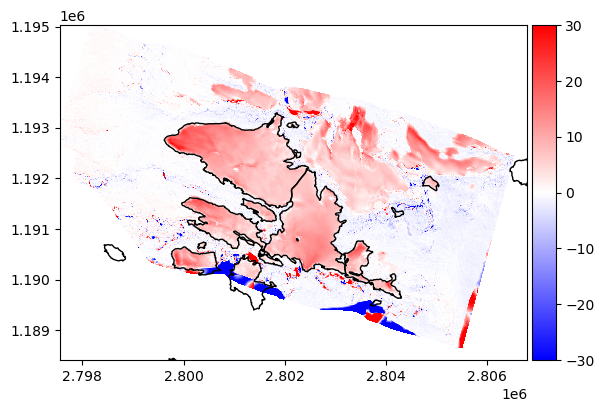

In [113]:
f, ax = plt.subplots()
diff.plot(ax=ax, cmap='bwr', vmin=-30, vmax=30)
sgi.plot(ax=ax, facecolor='none')
ax.set_xlim([dem2014_reproj.bounds.left, dem2014_reproj.bounds.right])
ax.set_ylim([dem2014_reproj.bounds.bottom, dem2014_reproj.bounds.top])

### 3. Extracting data from rasters: points, polygons, multi-polygons

Oftentimes, we want to get information from raster datasets that are linked to vector datasets, e.g., values at points or within on or more polygons. Use the following lines of code to 

1) Extract the minimum, maximum, mean, median, and standard deviation of the ice thickness inside our glacier outline using [rasterio.mask](https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html)
2) Calculate the total ice volume! What additional information do you need?
3) Extract the minimum, maximum, mean, median for the sampling points you defined earlier.
4) Finally, try to adapt the code to work for a set of polygons (buffers around your points)

The ice thickness dataset is currently an xdem.DEM, which is not (yet) as versatile as their rasterio counterparts. Therefore, xdem has a to_rio_dataset method, which easily allows you to convert to a rasterio dataset and use all the methods there. Therefore, our first step is to convert from xdem.dem.DEM to rasterio.io.DatasetReader

In [114]:
thickness_rio = thickness_lv95.to_rio_dataset()

In [115]:
# use rasterio.mask() to mask 
masked_data, masked_transform = mask(thickness_rio, outline.geometry, crop=True, nodata=thickness_rio.nodata)

In [116]:
# Set the no-data values to NaNs to exclude them from the analysis
masked_data = np.ma.masked_equal(masked_data, thickness_rio.nodata)

In [117]:
stats = {
    'min': masked_data.min(),
    'max': masked_data.min(),
    'mean': masked_data.mean(),
    'median': np.ma.median(masked_data),
    'std': masked_data.std()
}

print("Zonal Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Zonal Statistics:
min: 0.0
max: 0.0
mean: 77.89014095920692
median: 79.30809783935547
std: 24.415327814459822


Calculate the volume of ice inside the outline! What additional information do you need?

In [118]:
stats['sum'] = masked_data.sum()

print("Zonal Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Zonal Statistics:
min: 0.0
max: 0.0
mean: 77.89014095920692
median: 79.30809783935547
std: 24.415327814459822
sum: 51903108.0


In [128]:
thickness_rio.transform

Affine(2.0, 0.0, 2797549.5,
       0.0, -2.0, 1195031.0)

In [119]:
V_ice = (stats.get("sum")*(thickness_rio.transform[0])**2)/1000000
print(V_ice)

207.612432


Now let's do this for our point dataset:

In [120]:
# sampling a raster dataset at predefined points or extracting information inside a 
# load geojson
sampling_points = gpd.read_file('./data/sampling_points.geojson')

In [121]:
# Create a list to store raster values at points
raster_values_at_points = []

# Sample raster at each point
for index, point in sampling_points.iterrows():
    # Convert point coordinates to pixel coordinates
    pixel_coords = rasterio.transform.rowcol(thickness_rio.transform, point.geometry.x, point.geometry.y)

    # Get raster value at the pixel coordinate
    value = thickness_rio.read(1)[pixel_coords]

    # Add value to the list
    raster_values_at_points.append(value)

# Add raster values to GeoDataFrame
sampling_points['ice_thickness'] = raster_values_at_points

print(sampling_points)

   Points                         geometry  ice_thickness
0  Point1  POINT (2800379.700 1192725.200)      87.074844
1  Point2  POINT (2801251.500 1192437.900)     105.058449
2  Point3  POINT (2802045.600 1191907.400)     125.354164


Now we want to get stats for a series of polygons. Let's say we don't trust the individual point measurements, so we put a 50 m buffer around our initial points. 

In [122]:
sampling_points['buffered'] = sampling_points.geometry.buffer(50)

In [123]:
buffered_points = sampling_points.copy()
buffered_points = buffered_points.drop(['geometry','ice_thickness'], axis=1) #drop the point geometry and ice thickness attribute

In [124]:
# Take a look at the new geodataframe.  Can you reconstruct what the past few commands did?
buffered_points

,Points,buffered
0,Point1,"POLYGON ((2800429.700 1192725.200, 2800429.459..."
1,Point2,"POLYGON ((2801301.500 1192437.900, 2801301.259..."
2,Point3,"POLYGON ((2802095.600 1191907.400, 2802095.359..."


In [125]:
buffered_points = buffered_points.set_geometry('buffered') # set the geometry to "buffered"

Use your knowledge of the single-polygon and multiple point examples to complete the code below:

In [127]:
# Create a list to store raster values for polygons
raster_stats_for_polygons = []

# iterate over the rows of the dataframe:
for index, row in sampling_points.iterrows():

    # Run rasterio.mask on the polygon of the current row in the dataframe. Check the documentation if you are unsure about what datatypes 
    # the arguments reguire. 
    masked_data, masked_transform = mask(thickness_rio, [row.buffered], crop=True, nodata=thickness_rio.nodata)
    
    # Exclude nodata values from the masked array
    masked_data = np.ma.masked_equal(masked_data, thickness_rio.nodata)
    
    # Calculate statistics of the masked array
    stats = {
        'min': masked_data.min(),
        'max': masked_data.max(),
        'mean': masked_data.mean(),
        'median': np.ma.median(masked_data),
        'std': masked_data.std()
    }
    
    # Add statistics to the list
    raster_stats_for_polygons.append(stats)

# Add raster statistics to GeoDataFrame
buffered_points = buffered_points.assign(**{key: [stat[key] for stat in raster_stats_for_polygons] for key in raster_stats_for_polygons[0].keys()})

print(buffered_points)

   Points                                           buffered         min  \
0  Point1  POLYGON ((2800429.700 1192725.200, 2800429.459...   80.470650   
1  Point2  POLYGON ((2801301.500 1192437.900, 2801301.259...  100.587990   
2  Point3  POLYGON ((2802095.600 1191907.400, 2802095.359...  117.321289   

          max        mean      median       std  
0   91.845673   86.562738   86.725983  2.947770  
1  109.302391  105.290604  105.621429  1.938287  
2  130.457809  124.651689  124.850700  3.209107  


### 4. Writing raster data

Finally, let's look at how we can write out raster data that we create inside python as a geotiff (e.g. for sharing with others, or reloading for further processing)

1) Load the points from glathida that are inside the glacier outline.
2) Interpolate the ice thickness between the points.
3) Save the interpolated grid as a geotiff

Let's load some old data that we previously created

In [ ]:
points_inside = gpd.read_file('data/glathida_inside_sgi.geojson')

In [ ]:
# Extract the bounds of the polygon
minx, miny, maxx, maxy = outline.total_bounds
# Create an empty grid for interpolation
cell_size = 10 #m
grid_x, grid_y = np.meshgrid(np.arange(minx, maxx, cell_size), np.arange(maxy, miny, -cell_size)) # for a grid with 10m spacing

In [ ]:
points = np.column_stack([points_inside.geometry.x, points_inside.geometry.y])
values = points_inside['THICKNESS'].values

In [ ]:
grid_z = griddata(points, values, (grid_x, grid_y), method='linear') #try also cubic. Which one looks better?

In [ ]:
#check your work!
f, ax = plt.subplots()
#using imshow
ax.imshow(grid_z, extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], cmap='Blues')
#using contour
#ax.contourf(grid_x, grid_y, grid_z, cmap='Blues')

#add points from measurements
d = plt.scatter(
    points_inside.geometry.x,  # x-coordinates of points
    points_inside.geometry.y,  # y-coordinates of points
    c=points_inside['THICKNESS'],  # values to use for coloring
    cmap='Blues',  # colormap
    s=75,  # size of markers
    edgecolor='none',  # edge color of markers
    alpha=1  # transparency
)
outline.plot(ax=ax, facecolor='None')

In [ ]:
# set the affine transform parameters
pixel_width = cell_size
pixel_height = cell_size
transform = Affine.translation(grid_x.min(), grid_y.max()) * Affine.scale(pixel_width, -pixel_height)

In [ ]:
# set the relevant metadata
metadata = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': ..., # set appropriate no-data value
    'width': grid_z.shape[1],
    'height': grid_z.shape[0],
    'count': 1,
    'crs': ...,  # Example EPSG code, replace with appropriate CRS
    'transform': transform
}

In [ ]:
with rasterio.open('data/glathida_interpolated.tif', 'w', **metadata) as dst:
    dst.write(grid_z.astype('float32'), 1)
